# Mini Project: Dermatologist AI

## Introduction
In this notebook we'll try to design a model that can visually diagnose melanoma, the deadliest form of skin cancer. Here the model will try to distinguish this malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses)

The data and objective are pulled from the 2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection. As part of the challenge, participants were tasked to design an algorithm to diagnose skin lesion images as one of three different skin diseases (melanoma, nevus, or seborrheic keratosis). In this project, you will create a model to generate your own predictions.


In [1]:
ROOT = "/kaggle/input/derma-diseases/dataset"
!ls {ROOT}

test  train  validation


In [2]:
# importing libraries
import os
import cv2
import torch
import torchvision
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
from glob import glob
from tqdm import tqdm
import torch.nn as nn
from torch import optim
from PIL import ImageFile
from PIL import Image
import matplotlib.pyplot as plt
import time

## Calculating Mean and STD for our Dataset

In [3]:


data_imgs = np.array(glob(ROOT+"/*/*/*"))

average_im = torch.zeros(3)
average_im_square = torch.zeros(3)
for idx in tqdm(range(len(data_imgs))):
    img = Image.open(data_imgs[idx])
    img = transforms.Resize(224)(img)
    output = transforms.ToTensor()(img)
    average_im += torch.mean(output.view(3,-1), dim=1)
    average_im_square += torch.mean(output.view(3,-1)**2, dim=1)
average_im /= len(data_imgs)
std_im = np.sqrt(average_im_square/len(data_imgs) - average_im**2)
print(average_im)
print(std_im)

100%|██████████| 1403/1403 [00:07<00:00, 189.56it/s]


tensor([0.6908, 0.5535, 0.5109])
tensor([0.1494, 0.1543, 0.1641])


## Specify Transforms and Loaders

In [4]:
batch_size = 32

train_transforms = transforms.Compose([ 
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=average_im, std=std_im)
])


test_transforms = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=average_im, std=std_im)
    ])

# Specifying our training, validation, and test sets
train_data = datasets.ImageFolder(ROOT + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(ROOT + '/test', transform=test_transforms)
valid_data =  datasets.ImageFolder(ROOT + '/validation', transform=test_transforms)

# prepare the data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

dataset_size = len(train_data+test_data+valid_data)
classes_names = train_data.classes
classes_num = len(train_data.classes)
print("data set size: ", dataset_size)
print("Number of classes: ", classes_num)
print("Classes: ", classes_names)

data set size:  1403
Number of classes:  3
Classes:  ['melanoma', 'nevus', 'seborrheic_keratosis']


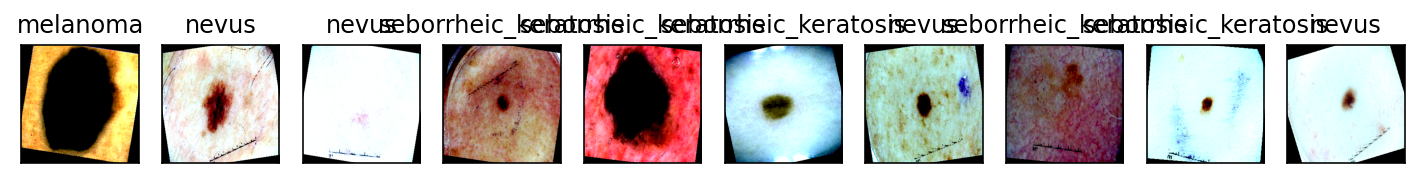

In [5]:
# visualizing Images from the first batch
%config InlineBackend.figure_format = 'retina'

def imshow(img):
  img = img /2+0.5 #unormalize the images
  plt.imshow(np.transpose(img, (1, 2, 0))) #convert it back from tensor to image

#get one batch of training images
dataiter = iter(trainloader) #now contains the first batch
images, labels = dataiter.next() #images=the first batch of images, labels= the first batch of labels
images = images.numpy() #convert the images to display them

#plot the imahes in the batch along with the corresponding labels
fig = plt.figure(figsize=(25,6))

for idx in np.arange(10):
  ax = fig.add_subplot(1, 20, idx+1, xticks=[], yticks=[]) #(rows, cols, index, .., ..)
  imshow(images[idx])
  ax.set_title(classes_names[labels[idx]])

In [6]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [7]:
# the following import is required for training to be robust to truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, trainloader, testloader, validloader , model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradient
            optimizer.zero_grad()
            output = model(data).logits
            aux1 = model(data).aux_logits
           
            
            ## find the loss and update the model parameters accordingly
            loss1 = criterion(output, target)
            loss2 = criterion(aux1, target)
            loss = loss1 + 0.4 * loss2 
            
            loss.backward()
            # Perform the optimizer step
            optimizer.step()
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += loss.item() * data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(validloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()           
            # Pass data acrss the network
            output = model(data)
            loss = criterion(output, target)
            ## update the average validation loss
            valid_loss += loss.item() * data.size(0)
        
        # Calculate the average losses
        train_loss = train_loss/len(trainloader)
        valid_loss = valid_loss/len(validloader)
    
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            valid_loss_min = valid_loss
            # print the decremnet in the validation
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min, 
            valid_loss))
            torch.save(model.state_dict(), save_path)
            
    # return trained model
    return model


In [8]:
def test(testloader, model, criterion, use_cuda):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(testloader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



## VGG Model
make sure of the following:
- that images are resized to 224X224 pixel
- the model returns only one output (ex: output = model(data))

In [ ]:
# Load the pretrained model
# define VGG16 model
VGG = models.vgg11(pretrained=True)
if use_cuda:
    VGG.cuda()
VGG

In [ ]:
# Building the network

#freeze the model calssifier
for param in  VGG.parameters():
    param.requires_grad = False

from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([                           
                          ('fc1', nn.Linear(4096, 1024)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(1024, classes_num)),
                          ('output', nn.LogSoftmax(dim=1))]))

VGG.classifier[6] = classifier
if use_cuda:
    VGG = VGG.cuda()
VGG

In [ ]:

# Initializing the weights
VGG.classifier.apply(weights_init_normal)

In [ ]:
#specify lr
lr = 0.01 * batch_size/256
# Specify Loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(VGG.classifier.parameters(), lr=lr, momentum=0.9)

In [ ]:
# Train our model
model = train(50, trainloader, testloader, validloader,
                       VGG, optimizer, criterion, use_cuda, 'dermatologist_ai.pt')


In [ ]:
# load the model that got the best validation accuracy
model.load_state_dict(torch.load('dermatologist_ai.pt'))

In [ ]:
# test our model on the testin set
test(testloader, model, criterion, use_cuda)

In [ ]:
# Predict random images
if train_on_gpu:
    images = images.cuda()

#get sample outputs
output = model(images)
#convert probabilties to prediction class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(number_classes):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## Inception
- ensure that images are resized to 299X299 pixel
- the model returns multiple outputs so we need to change the following in the training:
` output = model(data).logits`
`aux1 = model(data).aux_logits`

In [9]:
# Load the pretrained model
# define Inception model
# set aux_logits=True since we are using the model for training
Inception = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', aux_logits=True, pretrained=True)
Inception

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [10]:
# Building the network

#freeze the model calssifier
for param in  Inception.parameters():
    param.requires_grad = False

from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([                           
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.5)),
                          ('fc2', nn.Linear(1024, 1024)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.5)),
                          
                          ('fc3', nn.Linear(1024, classes_num)),
                          ('output', nn.LogSoftmax(dim=1))]))

Inception.fc = classifier
if use_cuda:
    Inception = Inception.cuda()
Inception

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [11]:
# apply normal distribution rule ro initialize the weights
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    
    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        # m.weight.data shoud be taken from a normal distribution
        n = m.in_features
        y = 1.0/np.sqrt(n)    
        m.weight.data.normal_(0, y)
        # m.bias.data should be 0
        m.bias.data.fill_(0)


In [12]:
# Initializing the weights
Inception.fc.apply(weights_init_normal)

Sequential(
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=3, bias=True)
  (output): LogSoftmax()
)

In [13]:
#specify lr
#lr = 0.01 * batch_size/256
# Specify Loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(Inception.fc.parameters(), lr=0.0005, momentum=0.9)


In [ ]:
# Train our model
model = train(100, trainloader, testloader, validloader,
                       Inception, optimizer, criterion, use_cuda, 'dermatologist_ai.pt')


Epoch: 1 	Training Loss: 38.706078 	Validation Loss: 25.581528
Validation loss decreased (25.581528 --> 25.581528).  Saving model ...
Epoch: 2 	Training Loss: 37.979842 	Validation Loss: 24.727179
Validation loss decreased (24.727179 --> 24.727179).  Saving model ...
Epoch: 3 	Training Loss: 36.369587 	Validation Loss: 23.737507
Validation loss decreased (23.737507 --> 23.737507).  Saving model ...
Epoch: 4 	Training Loss: 35.930026 	Validation Loss: 23.336288
Validation loss decreased (23.336288 --> 23.336288).  Saving model ...
Epoch: 5 	Training Loss: 34.990525 	Validation Loss: 22.737465
Validation loss decreased (22.737465 --> 22.737465).  Saving model ...
Epoch: 6 	Training Loss: 34.609198 	Validation Loss: 22.308042
Validation loss decreased (22.308042 --> 22.308042).  Saving model ...
Epoch: 7 	Training Loss: 32.686390 	Validation Loss: 22.010249
Validation loss decreased (22.010249 --> 22.010249).  Saving model ...
Epoch: 8 	Training Loss: 32.914436 	Validation Loss: 21.539271

In [ ]:
# load the model that got the best validation accuracy
model.load_state_dict(torch.load('dermatologist_ai.pt'))

In [ ]:
# test our model on the testin set
test(testloader, model, criterion, use_cuda)

### Additional Work:

In [ ]:
# Predict a given image
def predict(img_path):
    # load the image and return the predicted breed
    # pre_process the image
    t_batch = process_img(img_path, 224)
    Resnet.eval()
    t_batch = t_batch.cuda()
    output = model_transfer(t_batch)
    _, pred = torch.max(output, 1)    
    class_name = classes[int(pred)]
    return class_name

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim(-0.5, len(names) - 0.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Graphical analytics
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
names = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)